In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

# Load dataset
df = pd.read_csv("../datasets/cleaned_crime_data2.csv", parse_dates=['datetime'])
df.head()


,datetime,Latitude,Longitude,city,crime_category,description
0,2016-06-18 00:39:00,39.28315,-76.57834,Baltimore,Other,O
1,2016-06-18 01:53:00,39.29556,-76.58446,Baltimore,Other,O
2,2016-06-18 02:35:00,39.28919,-76.53914,Baltimore,Other,O
3,2016-06-18 02:35:00,39.28919,-76.53914,Baltimore,Other,O
4,2016-06-18 04:00:00,39.29173,-76.61713,Baltimore,Other,O


In [4]:
# Extract temporal features
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

# Drop rows with missing target or features
df.dropna(subset=['crime_category', 'description'], inplace=True)

# Define features and target
X = df[['Latitude', 'Longitude', 'hour', 'day_of_week', 'month', 'city', 'description']]
y = df['crime_category']


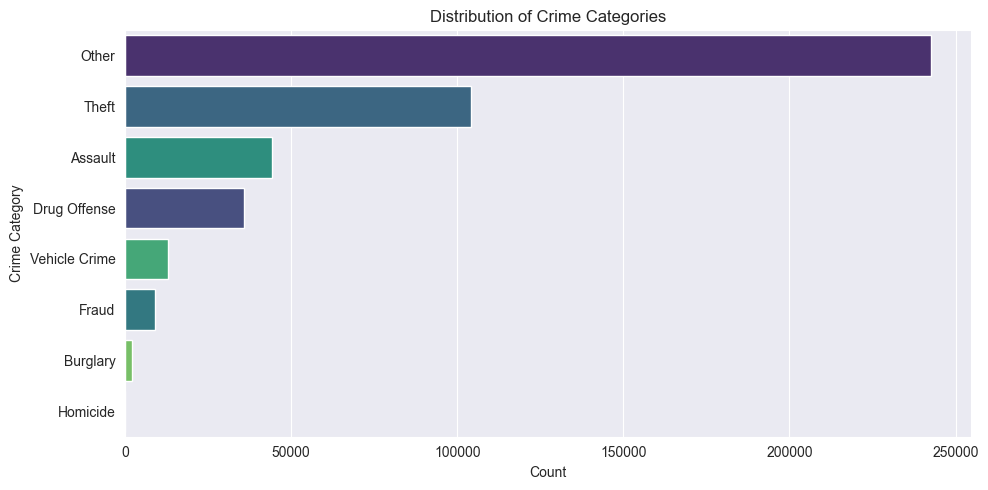

In [12]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='crime_category', order=df['crime_category'].value_counts().index, hue='crime_category', palette='viridis', legend=False)
plt.title("Distribution of Crime Categories")
plt.xlabel("Count")
plt.ylabel("Crime Category")
plt.tight_layout()
plt.show()


In [6]:
# Categorical & numeric features
categorical_features = ['city', 'description']
numeric_features = ['Latitude', 'Longitude', 'hour', 'day_of_week', 'month']

# Preprocessing with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # keep numeric features
)

# Random Forest classification pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)


In [8]:
# Classification report
print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred))


🔍 Classification Report:

               precision    recall  f1-score   support

      Assault       1.00      1.00      1.00      8916
     Burglary       1.00      1.00      1.00       396
 Drug Offense       1.00      1.00      1.00      7247
        Fraud       1.00      1.00      1.00      1708
        Other       1.00      1.00      1.00     48485
        Theft       1.00      1.00      1.00     20784
Vehicle Crime       1.00      1.00      1.00      2526

     accuracy                           1.00     90062
    macro avg       1.00      1.00      1.00     90062
 weighted avg       1.00      1.00      1.00     90062



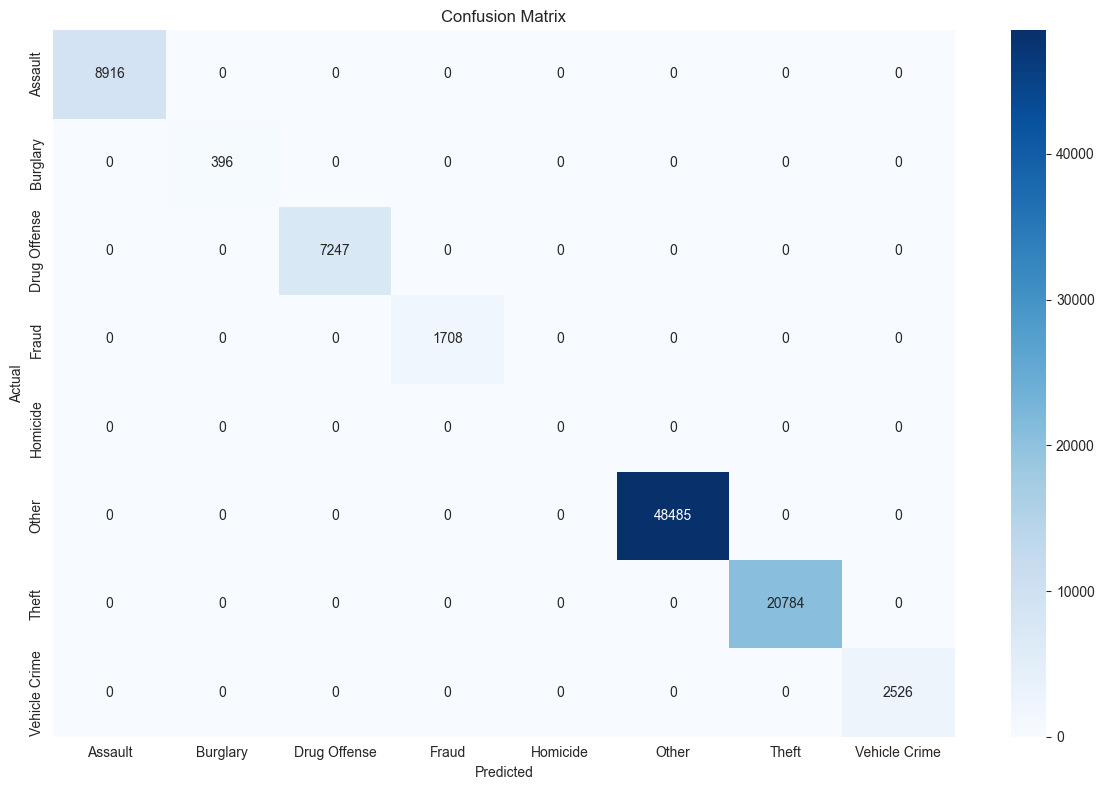

In [9]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


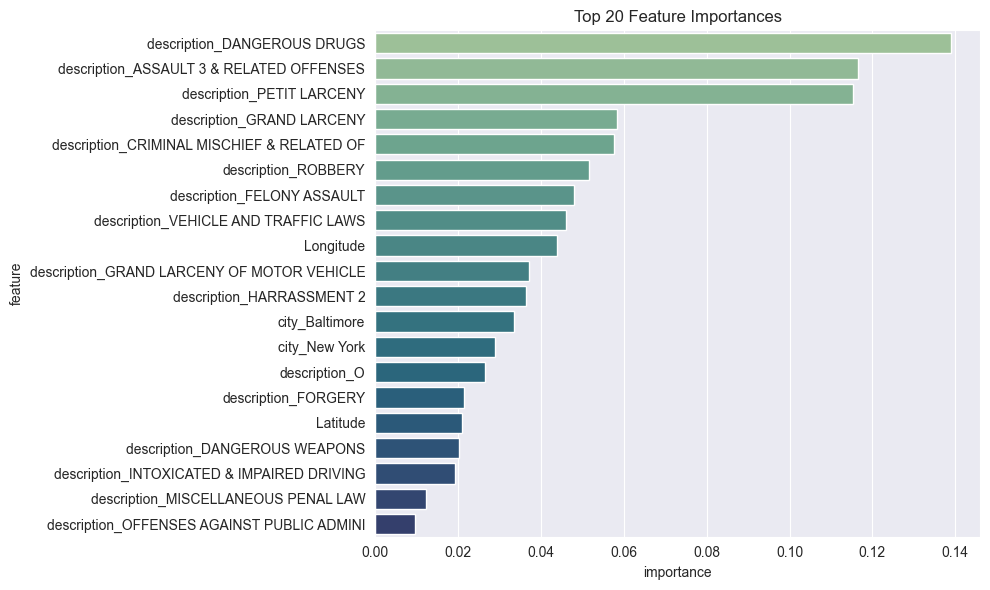

In [13]:
# Get feature importances
rf = pipeline.named_steps['classifier']
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = list(cat_feature_names) + numeric_features

importances = rf.feature_importances_
feature_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_df.sort_values(by='importance', ascending=False, inplace=True)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df.head(20), x='importance', y='feature', hue='feature', palette='crest', legend=False)

plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [11]:
joblib.dump(pipeline, 'crime_category_model.pkl')
print("✅ Model saved as crime_category_model.pkl")


✅ Model saved as crime_category_model.pkl
